<h1>TF Mutiple Hidden Layers: Regression on Boston Data</h1>
<br />
This is adapted from Frossard's <a href="http://www.cs.toronto.edu/~frossard/post/tensorflow/">tutorial</a>.
<br />
This approach is not batched, and the number of layers is fixed.
<br />
<br />
D. Thiebaut
<br />August 2016


<h2>Import the Libraries and Tools</h2>

In [16]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import learn
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn import metrics
from __future__ import print_function

%matplotlib inline

<h2>Import the Boston Data</h2>
<br />
We don't worry about adding column names to the data.

In [17]:
boston = learn.datasets.load_dataset('boston')
#print( "boston = ", boston )
x, y = boston.data, boston.target
y.resize( y.size, 1 ) #make y = [[x], [x], [x], ... ]

train_x, test_x, train_y, test_y = cross_validation.train_test_split(
                                    x, y, test_size=0.2, random_state=42)

print( "Dimension of Boston test_x = ", test_x.shape )
print( "Dimension of test_y = ", test_y.shape )

print( "Dimension of Boston train_x = ", train_x.shape )
print( "Dimension of train_y = ", train_y.shape )


Dimension of Boston test_x =  (102, 13)
Dimension of test_y =  (102, 1)
Dimension of Boston train_x =  (404, 13)
Dimension of train_y =  (404, 1)


We scale the inputs to have mean 0 and standard variation 1.

In [18]:
scaler = preprocessing.StandardScaler( )
train_x = scaler.fit_transform( train_x )
test_x  = scaler.fit_transform( test_x )

We verify that we have 13 features...

In [19]:
numFeatures =  train_x.shape[1] 

print( "number of features = ", numFeatures )

number of features =  13


<h2>Input & Output Place-Holders</h2>
<br />
Define 2 place holders to the graph, one for the inputs one for the outputs...

In [20]:
with tf.name_scope("IO"):
    inputs = tf.placeholder(tf.float32, [None, numFeatures], name="X")
    outputs = tf.placeholder(tf.float32, [None, 1], name="Yhat")

<h2>Define the Coeffs for the Layers</h2>
<br />
For each layer the input vector will be multiplied by a matrix $h$ of dim $n$ x $m$, where $n$ is the dimension of the input vector and $m$ the dimention of the output vector.   Then a bias vector of dimension $m$ is added to the product.

In [21]:
with tf.name_scope("LAYER"):
    # network architecture
    Layers = [numFeatures, 52, 39, 26, 13, 1]
    
    h1   = tf.Variable(tf.random_normal([Layers[0], Layers[1]], 0, 0.1, dtype=tf.float32), name="h1")
    h2   = tf.Variable(tf.random_normal([Layers[1], Layers[2]], 0, 0.1, dtype=tf.float32), name="h2")
    h3   = tf.Variable(tf.random_normal([Layers[2], Layers[3]], 0, 0.1, dtype=tf.float32), name="h3")
    h4   = tf.Variable(tf.random_normal([Layers[3], Layers[4]], 0, 0.1, dtype=tf.float32), name="h4")
    hout = tf.Variable(tf.random_normal([Layers[4], Layers[5]], 0, 0.1, dtype=tf.float32), name="hout")

    b1   = tf.Variable(tf.random_normal([Layers[1]], 0, 0.1, dtype=tf.float32 ), name="b1" )
    b2   = tf.Variable(tf.random_normal([Layers[2]], 0, 0.1, dtype=tf.float32 ), name="b2" )
    b3   = tf.Variable(tf.random_normal([Layers[3]], 0, 0.1, dtype=tf.float32 ), name="b3" )
    b4   = tf.Variable(tf.random_normal([Layers[4]], 0, 0.1, dtype=tf.float32 ), name="b4" )
    bout = tf.Variable(tf.random_normal([Layers[5]], 0, 0.1, dtype=tf.float32 ), name="bout" )

<h2>Define the Layer operations as a Python funtion</h2>

In [22]:
def model( inputs, layers ):
    [h1, b1, h2, b2, h3, b3, hout, bout] = layers
    y1 = tf.add( tf.matmul(inputs, h1), b1 )
    y1 = tf.nn.sigmoid( y1 )
       
    y2 = tf.add( tf.matmul(y1, h2), b2 )
    y2 = tf.nn.sigmoid( y2 )

    y3 = tf.add( tf.matmul(y2, h3), b3 )
    y3 = tf.nn.sigmoid( y3 )

    y4 = tf.add( tf.matmul(y3, h4), b4 )
    y4 = tf.nn.sigmoid( y4 )

    yret  = tf.matmul(y4, hout) + bout 
    return yret

<h2>Define the operations that are performed</h2>
<br />
We define what happens to the inputs (x), when they are provided, and what we do with 
the outputs of the layers (compare them to the y values), and the type of minimization 
that must be done.

In [23]:
with tf.name_scope("train"):
    learning_rate = 0.50
    yout = model( inputs, [h1, b1, h2, b2, h3, b3, hout, bout] )
    
    cost_op = tf.reduce_mean( tf.pow( yout - outputs, 2 ))
    #cost_op = tf.reduce_sum( tf.pow( yout - outputs, 2 ))
    #cost_op =  tf.reduce_mean(-tf.reduce_sum( yout * tf.log( outputs ) ) )

    #train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_op)
    #train_op = tf.train.AdamOptimizer( learning_rate=learning_rate ).minimize( cost_op )
    train_op = tf.train.AdagradOptimizer( learning_rate=learning_rate ).minimize( cost_op )

<h2>Train the Model</h2>
<br />
We are now ready to go through many sessions, and in each one train the model.  Here we train on the whole x-train and y-train data, rather than batching into smaller groups.

In [24]:
# define variables/constants that control the training
epoch = 0
last_cost = 0
max_epochs = 50000
tolerance = 1e-6

print( "Beginning Training" )

sess = tf.Session() # Create TensorFlow session
with sess.as_default():
    
    # initialize the variables
    init = tf.initialize_all_variables()
    sess.run(init)
    
    # start training until we stop, either because we've reached the max
    # number of epochs, or successive errors are close enough to each other
    # (less than tolerance)
    
    costs = []
    epochs= []
    while True:
        # Do the training
        sess.run( train_op, feed_dict={inputs: train_x, outputs: train_y} )
            
        # Update the user every 1000 epochs
        if epoch % 1000==0:
            cost = sess.run(cost_op, feed_dict={inputs: train_x, outputs: train_y})
            costs.append( cost )
            epochs.append( epoch )
            
            print( "Epoch: %d - Error: %.4f" %(epoch, cost) )
            
            # time to stop?
            if epoch > max_epochs :
                # or abs(last_cost - cost) < tolerance:
                print( "STOP!" )
                break
            last_cost = cost
            
        epoch += 1
    
    # we're done...
    # print some statistics...
    
    print( "Test Cost =", sess.run(cost_op, feed_dict={inputs: test_x, outputs: test_y}) )

    # compute the predicted output for test_x
    pred_y = sess.run( yout, feed_dict={inputs: test_x, outputs: test_y} )
    
    print( "\nPrediction\nreal\tpredicted" )
    for (y, yHat ) in zip( test_y, pred_y )[0:10]:
        print( "%1.1f\t%1.1f" % (y, yHat ) )
    

Beginning Training
Epoch: 0 - Error: 406.0418
Epoch: 1000 - Error: 5.6299
Epoch: 2000 - Error: 3.2823
Epoch: 3000 - Error: 2.7294
Epoch: 4000 - Error: 2.5422
Epoch: 5000 - Error: 2.3896
Epoch: 6000 - Error: 2.2441
Epoch: 7000 - Error: 2.1843
Epoch: 8000 - Error: 2.1206
Epoch: 9000 - Error: 1.7072
Epoch: 10000 - Error: 1.3639
Epoch: 11000 - Error: 1.0263
Epoch: 12000 - Error: 0.8089
Epoch: 13000 - Error: 0.6670
Epoch: 14000 - Error: 0.5102
Epoch: 15000 - Error: 0.4037
Epoch: 16000 - Error: 0.3435
Epoch: 17000 - Error: 0.2700
Epoch: 18000 - Error: 0.2161
Epoch: 19000 - Error: 0.1671
Epoch: 20000 - Error: 0.1435
Epoch: 21000 - Error: 0.1176
Epoch: 22000 - Error: 0.0976
Epoch: 23000 - Error: 0.0816
Epoch: 24000 - Error: 0.0662
Epoch: 25000 - Error: 0.0612
Epoch: 26000 - Error: 0.0524
Epoch: 27000 - Error: 0.0458
Epoch: 28000 - Error: 0.0407
Epoch: 29000 - Error: 0.0340
Epoch: 30000 - Error: 0.0336
Epoch: 31000 - Error: 0.0303
Epoch: 32000 - Error: 0.0278
Epoch: 33000 - Error: 0.0257
Epoch:

<h2>R2 score</h2>
<br />

In [25]:
r2 =  metrics.r2_score(test_y, pred_y) 
print( "mean squared error = ", metrics.mean_squared_error(test_y, pred_y))
print( "r2 score (coef determination) = ", metrics.r2_score(test_y, pred_y))

mean squared error =  13.6573081195
r2 score (coef determination) =  0.81498519045


<h2>Plot Prediction vs. Real Housing Price</h2>

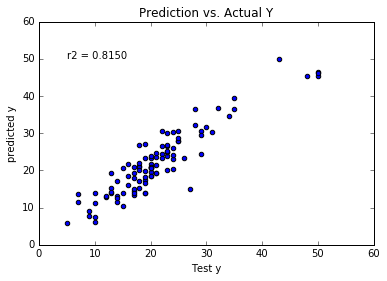

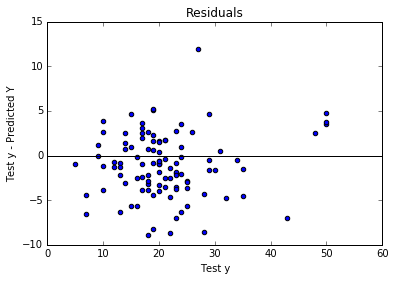

In [41]:
    
    fig = plt.figure()
    plt.scatter( test_y, pred_y )
    plt.text(5, 50, r'r2 = %1.4f' % r2)
    plt.xlabel( "Test y" )
    plt.ylabel( "predicted y" )
    plt.title( "Prediction vs. Actual Y" )
    #plt.save( "images/sigmoid_adagrad_52_39_26_13_1.png")
    plt.show()
    fig.savefig('PredVsRealBoston.png', bbox_inches='tight')
    
    fig = plt.figure()
    plt.scatter( test_y, test_y - pred_y )
    plt.axhline(0, color='black')
    plt.xlabel( "Test y" )
    plt.ylabel( "Test y - Predicted Y" )
    plt.title( "Residuals" )
    plt.show()
    fig.savefig('ResidualsBoston.png', bbox_inches='tight')
    

<h2>Plot Cost vs Epochs</h2>

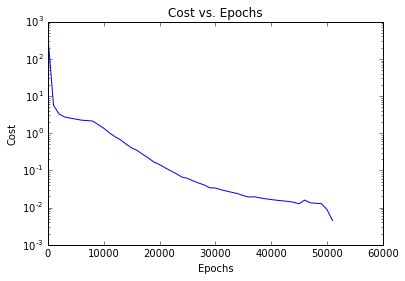

In [42]:
    fig = plt.figure()
    plt.semilogy( epochs, costs )
    plt.xlabel( "Epochs" )
    plt.ylabel( "Cost" )
    plt.title( "Cost vs. Epochs")
    plt.show()
    fig.savefig('CostVsEpochs.png', bbox_inches='tight')